## Predict how much energy will a building consume with Fedot.Industrial

Dataset published on Kaggle, aims to assess the value of energy efficiency improvements. For that purpose, four types of sources are identified: electricity, chilled water, steam and hot
water. The goal is to estimate the **energy consumption in kWh**. Dimensions correspond to the air temperature, dew temperature, wind direction and wind speed. These values were taken hourly during a week, and the output is the meter reading of the four aforementioned sources. In this way, was created four datasets:  **ChilledWaterPredictor**, **ElectricityPredictor**, **HotwaterPredictor**, and **SteamPredictor**.
Link to the dataset - https://www.kaggle.com/code/fatmanuranl/ashrae-energy-prediction2

In [1]:
import pandas as pd

from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.core.architecture.preprocessing.DatasetLoader import DataLoader
from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels
from examples.example_utils import init_input_data, calculate_regression_metric

The list of basic fedot industrial models for experiment are shown below. We using simple linear machine learning pipelines with 3 different feature generators: Statistical, Reccurence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [2]:
model_dict = {
    'regression_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                       params={'window_size': 5}).add_node('ridge'),
    'regression_pca_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                           params={'window_size': 5}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).add_node('ridge'),
    'regression_pca_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_pca_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge')
}
metric_dict = {}
dataset_name = 'ElectricityPredictor'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [3]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2023-10-03 16:17:25,911 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/ElectricityPredictor


In [4]:
input_data = init_input_data(train_data[0], train_data[1], task='regression')

Lets check our data.

In [5]:
input_data.features.shape

(567, 4, 168)

Lets visualise our predictors.

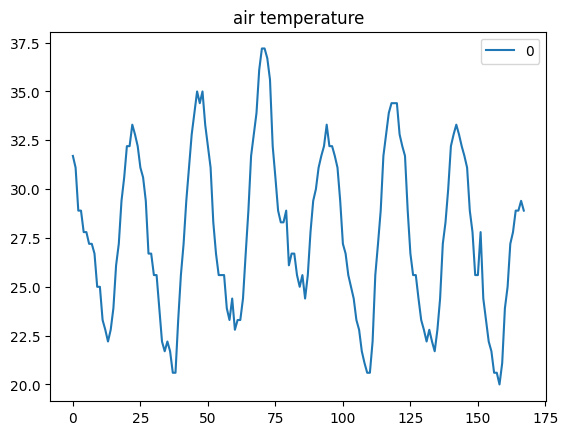

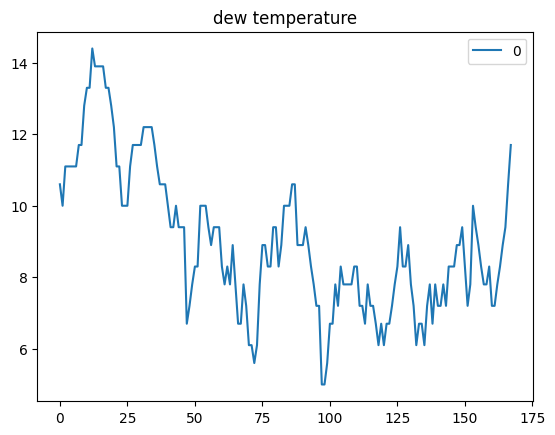

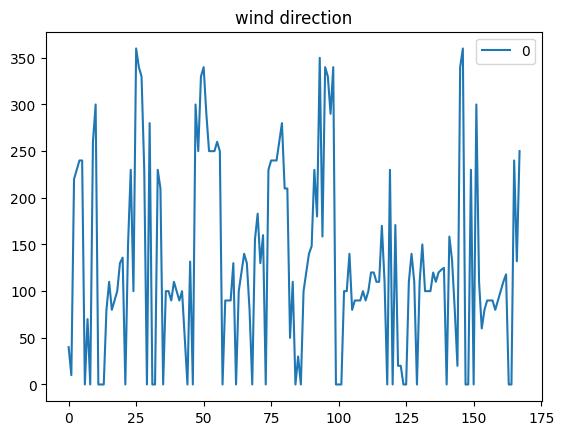

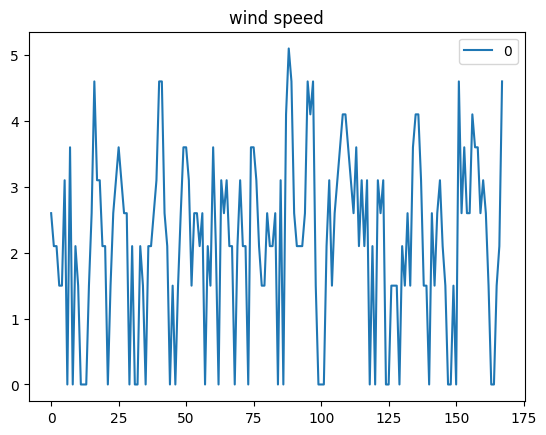

In [6]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='air temperature')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='dew temperature')
pd.DataFrame(input_data.features[1, 2, :]).plot(title='wind direction')
pd.DataFrame(input_data.features[1, 3, :]).plot(title='wind speed')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [7]:
input_data = init_input_data(train_data[0], train_data[1], task='regression')
val_data = init_input_data(test_data[0], test_data[1], task='regression')
with IndustrialModels():
    for model in model_dict.keys():
        print(f'Current_model - {model}')
        pipeline = model_dict[model].build()
        pipeline.fit(input_data)
        features = pipeline.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric_dict.update({model: metric})

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [8]:
print(metric_dict)

{'regression_with_statistical_features':                                       0
r2_score:                     -1.644464
mean_squared_error:       698406.082747
root_mean_squared_error:     835.706936
mean_absolute_error          604.766705
median_absolute_error        424.789912
explained_variance_score      -1.606454
max_error                   2413.925700
d2_absolute_error_score       -2.135276, 'regression_pca_with_statistical_features':                                       0
r2_score:                     -0.002798
mean_squared_error:       264840.107063
root_mean_squared_error:     514.626182
mean_absolute_error          261.164925
median_absolute_error        133.701291
explained_variance_score      -0.001518
max_error                   2337.330582
d2_absolute_error_score       -0.353950, 'regression_with_reccurence_features':                                       0
r2_score:                      0.038808
mean_squared_error:       253851.946498
root_mean_squared_error:     503.8